In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from tensorflow.keras.preprocessing import image


In [64]:
# df = pd.read_csv('train.csv', header=None)
# df.columns = ['ImageId', 'NameOfPokemon']

# label_dictionary = {'Pikachu':0, "Bulbasaur":1, "Charmander":2}
# image_dir = Path("./Images")
# image_data = []
# labels = []

# for i, row in df.iterrows():
#     img_name = row['ImageId']
#     label_name = row['NameOfPokemon']

#     img_path = image_dir/img_name
#     img = krs.load_img(img_path, target_size=(100,100))
#     img_array = krs.img_to_array(img)
#     image_data.append(img_array)
#     labels.append(label_dictionary[label_name])




df = pd.read_csv('train.csv')
df.columns = ['ImageId', 'NameOfPokemon']

label_dictionary = {'Pikachu': 0, "Bulbasaur": 1, "Charmander": 2}
image_dir = Path("./Images")
image_data = []
labels = []

for i, row in df.iterrows():
    img_name = row['ImageId']
    label_name = row['NameOfPokemon']

    img_path = image_dir / img_name
    img = image.load_img(img_path, target_size=(100, 100))
    img_array = image.img_to_array(img)
    image_data.append(img_array)
    labels.append(label_dictionary[label_name])


c:\Users\sanid\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [65]:
print(len(image_data))
print(len(labels))

304
304


In [66]:
image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)

In [67]:
image_data.shape

(304, 100, 100, 3)

In [68]:
labels.shape

(304,)

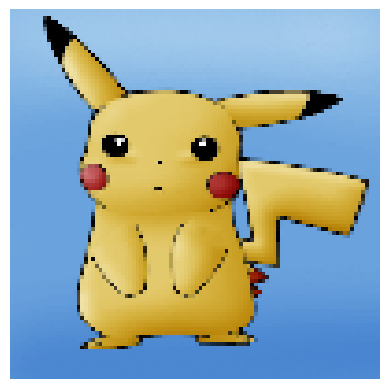

In [69]:
def display_img(img):
    plt.axis('off')
    plt.imshow(img)

    return

display_img(image_data[0])

In [70]:
import random
combined_data = list(zip(image_data, labels))
random.shuffle(combined_data)

image_data, labels = zip(*combined_data)
image_data = np.array(list(image_data))
labels = np.array(list(labels))

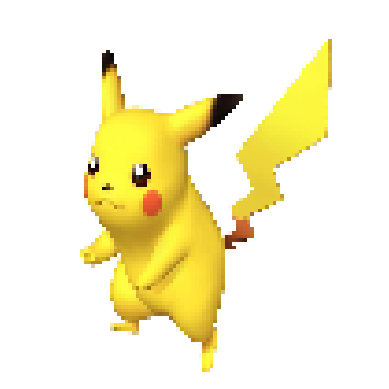

In [74]:
display_img(image_data[0])

In [75]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.B = 0
        
    def hingeloss(self, W,X,Y,B):
        loss = 0.0
        loss += (np.dot(W,W.T))//2
        for i in range(X.shape[0]):
            ti = Y[i] * (np.dot(W, X[i].T) + B)
            loss += self.C * max(0, (1-ti))
        return loss[0][0]


    def fit(self, X, Y, batch_size = 100, learning_rate = 0.001):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]

        W = np.zeros((1,no_of_features))
        bias = 0
        print(self.hingeloss(W,X,Y,bias))

        losses = []

        for i in range(300):
            l = self.hingeloss(W,X,Y,bias)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)

            for batch_start in range(0, no_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_start, batch_start+batch_size):
                    if j < no_of_samples:
                        i = ids[j]
                        ti = Y[i]*(np.dot(W,X[i].T)+bias)
                        if ti>1:
                            pass
                        elif ti<1:
                            gradw += self.C*Y[i]*X[i]
                            gradb += self.C*Y[i]

                W = W-learning_rate*W + learning_rate*gradw
                bias = bias + learning_rate*gradb
            losses.append(l)
        self.W = W
        self.B = bias
        return W, bias, losses
    

In [76]:
image_data = image_data.reshape(image_data.shape[0], -1)
print(image_data.shape)
print(labels.shape)

(304, 30000)
(304,)


In [77]:
no_of_classes = 3
def classwise(X,Y):
    data = {}

    for i in range(3):
        data[i] = []

    for i in range(image_data.shape[0]):
        data[Y[i]].append(X[i])

    for j in data.keys():
        data[j] = np.array(data[j])

    return data

In [78]:
data = classwise(image_data, labels)
print(data[2].shape[0])

102


In [79]:
def pairingforSVM(d1, d2):
    l1, l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    data_pair = np.zeros((samples, features))
    data_labels = np.zeros((samples,))

    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2

    data_labels[:l1] = -1
    data_labels[l1:] = +1

    return data_labels, data_pair

In [80]:
mySVM = SVM()
def trainSVM(X,Y):
    svm_classifier = {}
    for i in range(3):
        svm_classifier[i] = {}
        for j in range(i+1, 3):
            Ypari, Xpair = pairingforSVM(data[i], data[j])
            w,b,loss = mySVM.fit(Xpair, Ypari)
            svm_classifier[i][j] = (w,b)

    return svm_classifier

In [81]:
svm_classifier = trainSVM(image_data, labels)

202.0
203.0
203.0


In [82]:
image_data.shape

(304, 30000)

In [83]:
def binarypredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return 0

In [84]:
def predict(X):
    count = np.zeros((3,))

    for i in range(3):
        for j in range(i+1, 3):
            w,b = svm_classifier[i][j]
            z = binarypredict(X,w,b)
            if z == 1:
                count[j] += 1
            else:
                count[i] += 1
    final_prediction = np.argmax(count)
    return final_prediction

In [86]:
print(predict(image_data[4]))

2


In [87]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(100, 100))
    img_array = image.img_to_array(img)
    img_array = img_array.reshape(1, -1)  # Flatten image
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def predict_pokemon(img_path):
    preprocessed_img = preprocess_image(img_path)
    prediction = predict(preprocessed_img)
    if prediction == 0:
        print("Pikachu")
    elif prediction == 1:
        print("Bulbasaur")
    elif prediction == 2:
        print("Charmander")

In [90]:
predict_pokemon('JdWGXQf.jpg')

Charmander
